# 1. Data & Imports 

In [1]:
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

In [2]:
import keras
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# constants
#path = 'C:/Users/monte/Documents/Memoria/src'
path = 'C:/Users/asus/Documents/2023_2/Memoria/src'


# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()


# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_v2.csv')

Using TensorFlow backend


# 2. Data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

x_scaler = x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)
x_obs = x_scaler.transform(X_obs.values)

formatted_x_train = np.expand_dims(x_train, axis=2) #This step it's very important an CNN will only accept this data shape
formatted_x_val = np.expand_dims(x_val, axis=2)
formatted_x_test = np.expand_dims(x_test, axis=2)
formatted_x_obs = np.expand_dims(X_obs, axis=2)



c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [4]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[1]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# 3. NN Training

In [5]:
from keras_tuner.engine import hyperparameters as hp

# convBlock
conv_kernel_size = hp.Choice("kernel_size", [2,3,5,7],)
conv_num_layers = hp.Choice("conv_layers", [1,2],)
conv_num_blocks = 1
conv_filters = hp.Choice("filters", [128,256],)

# # DenseBlock
dense_num_layers = hp.Choice("dense_layers", [2,3])
dense_units = hp.Choice("dense_units", [128,256])

# RegressionHead
# head_dropout = hp.Float(
#                 'dropout_head',
#                 min_value=0.0,
#                 max_value=0.5,
#                 default=0.25,
#                 step=0.05,
#             )

input = ak.Input()
conv1 = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(input)
conv2 = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(conv1)
dense = ak.DenseBlock(
  	num_layers=dense_num_layers, 
  	num_units=dense_units, 
  	use_batchnorm=False, 
  	#dropout=dense_dropout
)(conv2)
regression_output = ak.RegressionHead(
  	output_dim=3, 
   	loss="mse", 
    metrics=["mae"], 
    #dropout=head_dropout,
)(dense)


def generateAutoModel():
  return ak.AutoModel(
	inputs=input,
	outputs=regression_output,
	max_trials=50,
	loss='mse',
	metrics = 'mae',
	tuner='bayesian',
	overwrite=False,
	seed=global_seed,
	max_model_size=None,
 	project_name='raw_long_range_opt')



In [6]:
# set timer
curr_time = time.time()

In [7]:
# 2hrs 31 min
model = generateAutoModel()
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=20)


Reloading Tuner from .\raw_long_range_opt\tuner0.json
Epoch 1/20
459/459 [==============================] - 12s 11ms/step - loss: 0.0885 - mae: 0.2099 - val_loss: 0.0088 - val_mae: 0.0657
Epoch 2/20
459/459 [==============================] - 5s 10ms/step - loss: 0.0069 - mae: 0.0599 - val_loss: 0.0019 - val_mae: 0.0302
Epoch 3/20
459/459 [==============================] - 5s 10ms/step - loss: 0.0021 - mae: 0.0331 - val_loss: 6.3504e-04 - val_mae: 0.0158
Epoch 4/20
459/459 [==============================] - 5s 10ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 4.0279e-04 - val_mae: 0.0126
Epoch 5/20
459/459 [==============================] - 5s 10ms/step - loss: 8.7031e-04 - mae: 0.0216 - val_loss: 2.9176e-04 - val_mae: 0.0109
Epoch 6/20
459/459 [==============================] - 5s 10ms/step - loss: 7.0187e-04 - mae: 0.0195 - val_loss: 2.2731e-04 - val_mae: 0.0097
Epoch 7/20
459/459 [==============================] - 5s 10ms/step - loss: 5.9837e-04 - mae: 0.0181 - val_loss: 1.9999e-04 

INFO:tensorflow:Assets written to: .\raw_long_range_opt\best_model\assets


INFO:tensorflow:Assets written to: .\raw_long_range_opt\best_model\assets


In [8]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 1 minutes, 46.432321 seconds  ---


In [9]:
exp = model.export_model()
exp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 701, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 701, 1)           0         
 t32)                                                            
                                                                 
 conv1d (Conv1D)             (None, 699, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 349, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 347, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 173, 128)         0     

In [10]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(formatted_x_test, y_test)

print('loss: %.5f  MAE:%.5f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 1s 5ms/step - loss: 3.4247e-05 - mae: 0.0041
loss: 0.00003  MAE:0.00412


In [11]:
predictions = model.predict(formatted_x_test)

153/153 [==============================] - 0s 3ms/step


In [12]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.5f  MAE:%.4f'% (losses[0],maes[0]))
print('log g -       loss: %.5f  MAE:%.4f'% (losses[1],maes[1]))
print('v -           loss: %.5f  MAE:%.4f'% (losses[2],maes[2]))


Temperatura - loss: 0.00004  MAE:0.0045
log g -       loss: 0.00004  MAE:0.0046
v -           loss: 0.00002  MAE:0.0033


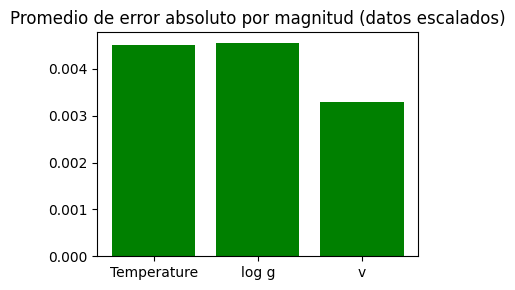

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(predictions-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [14]:
predictions = y_scaler.inverse_transform(predictions)

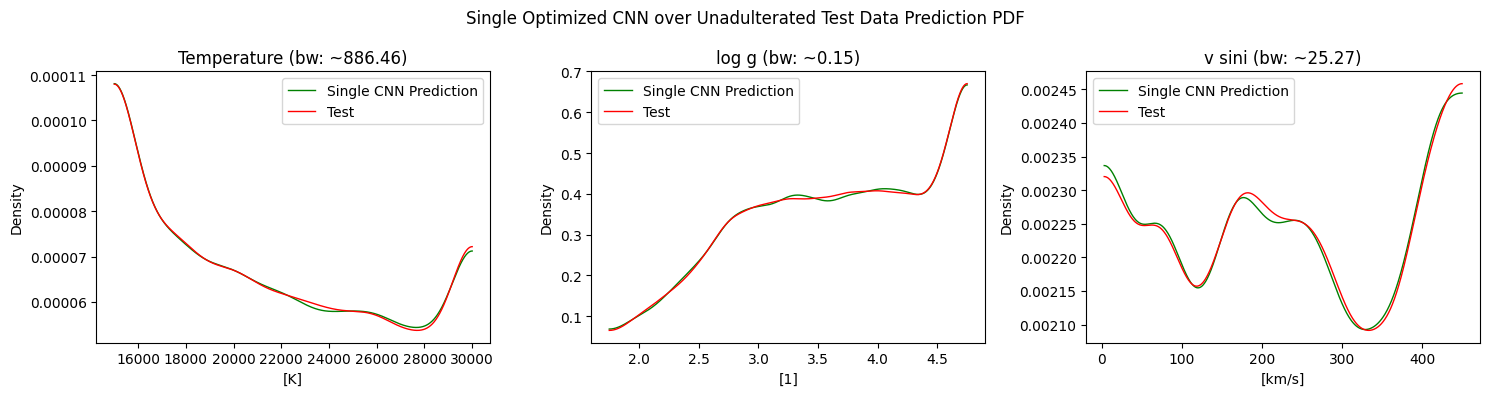

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Single CNN Prediction')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Density')
	axes[i].set_title(measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.suptitle('Single Optimized CNN over Unadulterated Test Data Prediction PDF')
plt.legend()
plt.tight_layout();
plt.show()

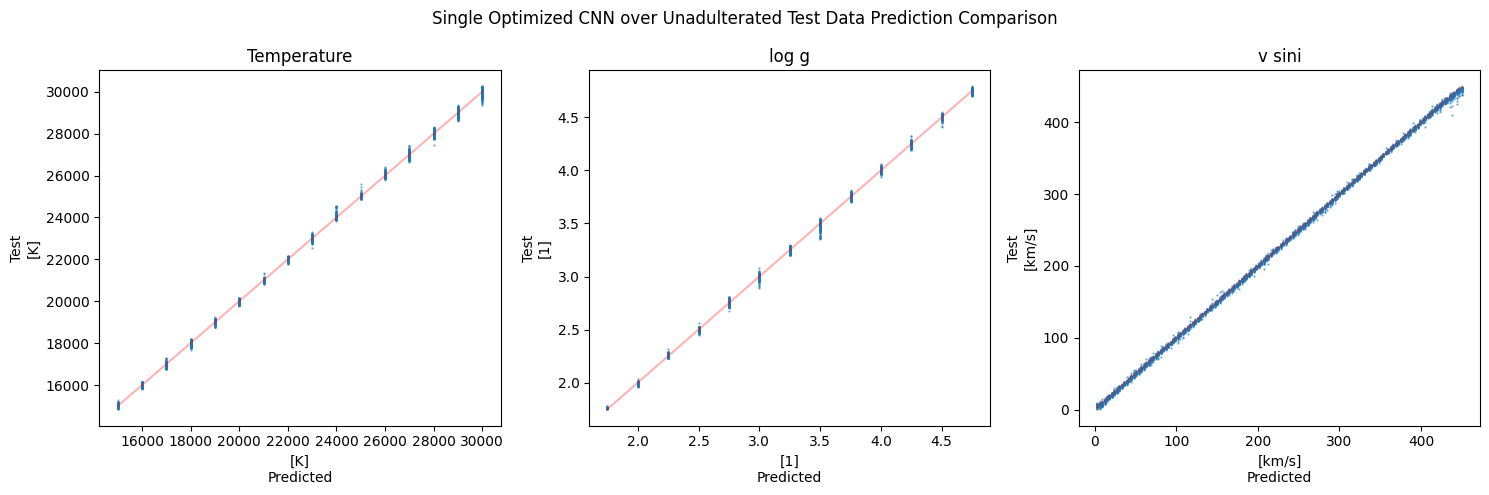

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Single Optimized CNN over Unadulterated Test Data Prediction Comparison')
plt.tight_layout();
plt.show()

In [17]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
# x_data = ['Temperature','log g','v']
# 
# diff = np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)
# axes.bar(x_data,diff, color='green')
# axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
# plt.tight_layout();
# plt.show()


## Resultados datos de testing

In [18]:
#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(predictions-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [19]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(20)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,16986,14 (0.1%),3.25,3.25,0.0 (0.1%),246,246,0 (0.1%)
1,18000,17982,18 (0.1%),2.75,2.77,0.02 (0.7%),285,284,1 (0.3%)
2,30000,30252,252 (0.8%),3.75,3.76,0.01 (0.2%),267,266,1 (0.3%)
3,23000,22914,86 (0.4%),2.5,2.5,0.0 (0.1%),63,63,0 (0.7%)
4,19000,19015,15 (0.1%),3.0,2.98,0.02 (0.8%),126,123,3 (2.3%)
5,17000,17061,61 (0.4%),4.5,4.52,0.02 (0.5%),156,156,0 (0.1%)
6,28000,27922,78 (0.3%),3.25,3.27,0.02 (0.5%),450,447,3 (0.8%)
7,22000,21963,37 (0.2%),4.0,4.02,0.02 (0.4%),285,283,2 (0.6%)
8,23000,23019,19 (0.1%),3.0,3.02,0.02 (0.6%),30,26,4 (12.1%)
9,23000,22918,82 (0.4%),4.5,4.49,0.01 (0.2%),153,154,1 (0.7%)


## Datos Observados

In [20]:
predictions = model.predict(formatted_x_obs)

3/3 [==============================] - 0s 13ms/step


In [21]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.124  MAE:0.286
log g -       loss: 0.161  MAE:0.382
v -           loss: 0.033  MAE:0.163


In [22]:
predictions = y_scaler.inverse_transform(predictions)

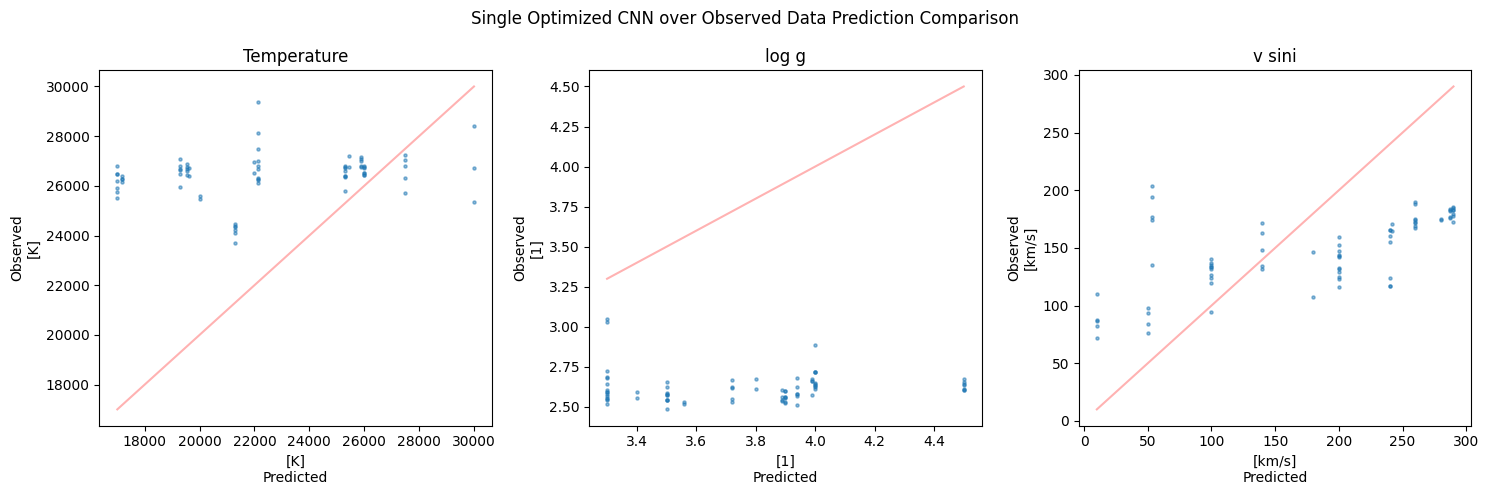

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=predictions[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Single Optimized CNN over Observed Data Prediction Comparison')
plt.tight_layout();
plt.show()

In [24]:
# xi
def xi(obs,sint):
  return np.sum((obs - sint)**2/sint)
def get_closest_spectra_line(index):
  obs = x_obs[index]
  min_dist = np.inf
  min_dist_index = -1
  for i, sint in enumerate(x):
    
    d = xi(obs, sint)
    if d < min_dist:
      min_dist = d
      min_dist_index = i
      
  return min_dist, min_dist_index

In [25]:
# find closest parameters
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
  
nearest = []
for obs_parameters in Y_obs.to_numpy():
	neighbor = []
	for param_index in range(len(target)):
		v, _ = find_nearest(Y.iloc[:,param_index].values,obs_parameters[param_index])
		neighbor.append(v)
	nearest.append(neighbor)
 
nearest_index = []
for neighbor in nearest:
	nearest_index.append(Y[(Y.temperature == neighbor[0]) & (Y.g == neighbor[1]) & (Y.v == neighbor[2])].index[0])

In [26]:
#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)
#close = np.array([get_closest_spectra_line(index) for index in range(len(X_obs))])[:,0]

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

# xi es la distancia entre el espectro observado y el espectro sintetico que tiene parámetros más cercanos a la estrella
table_formatted_xi = [xi(obs,sint) for obs, sint in zip(x_obs,X.iloc[nearest_index].to_numpy())]


In [27]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(20)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,26668,7142 (36.6%),3.3,2.57,0.73 (22.2%),287,184,103 (36.1%),1015.324415
33328,2013-01-18,03-39-09,19526,26601,7075 (36.2%),3.3,2.55,0.75 (22.6%),287,183,104 (36.2%),1538.537980
33328,2013-02-26,00-55-34,19526,26448,6922 (35.4%),3.3,2.55,0.75 (22.9%),287,182,105 (36.5%),1452.334310
33328,2015-02-25,23-58-07,19526,26741,7215 (36.9%),3.3,2.59,0.71 (21.4%),287,176,111 (38.7%),2072.617893
33328,2015-02-26,00-19-03,19526,26861,7335 (37.6%),3.3,2.61,0.69 (21.0%),287,177,110 (38.3%),2323.030009
35165,2014-03-20,23-53-54,17000,26204,9204 (54.1%),4.0,2.63,1.37 (34.2%),240,117,123 (51.2%),36281.421301
35165,2014-03-21,00-14-49,17000,25509,8509 (50.1%),4.0,2.61,1.39 (34.7%),240,117,123 (51.4%),44058.459074
35165,2014-03-21,00-35-18,17000,26783,9783 (57.5%),4.0,2.72,1.28 (32.1%),240,124,116 (48.5%),51722.541047
35165,2015-11-14,04-22-43,17000,25919,8919 (52.5%),4.0,2.65,1.35 (33.8%),240,155,85 (35.3%),53942.731906


# 4. Ensemble

In [28]:
import time
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

# set timer
curr_time = time.time()

In [5]:

import os

i_fp = open('raw_data_predictions/weights.txt','w')
i_fp.close()

NUM_MODELS = 3
for i in range(NUM_MODELS):
    i_fp = open('iteration.txt','w')
    i_fp.write(str(i))
    i_fp.close()
    os.system('''cd C:/Users/Asus/Documents/2023_2/Memoria & ./py310_tf/Scripts/activate.ps1 & cd src/2.1.parametersPredictionWorkflow & python raw_data_model_train.py''')


In [30]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 7 minutes, 53.087630 seconds  ---


### Datos de testing vs prediccion(ensamble)

In [31]:
# write & read predictions functions
import numpy as np
        
def read_predictions(fp,num_predictions):
    predictions = []
    lines = fp.readlines()
    for i in range(num_predictions):
        t, g, v = lines[i].split()
        predictions.append([float(t),float(g),float(v)])
    return np.array(predictions)

In [32]:
weights_fp = open('./raw_data_predictions/weights.txt','r')
weights = []
predictions = []
for i in range(NUM_MODELS):
    weights.append([1-float(weights_fp.readline().split()[0])])
    test_predictions_fp = open('./raw_data_predictions/test/'+str(i)+'.predictions.txt','r')
    predictions.append(y_scaler.inverse_transform(read_predictions(test_predictions_fp,len(x_test))))
    

weights = np.array(weights)
predictions = np.array(predictions)#.reshape((NUM_MODELS, len(x_test),len(target)))

In [33]:
# prediccion del ensamble e incerteza
weights = [(weight)/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(NUM_MODELS)])
uncertainty = sum([(ensemble_prediction-predictions[i])**2*weights[i] for i in range(NUM_MODELS)])**(1/2)


In [34]:
# metricas por parametro

losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.5f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.5f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.5f  MAE:%.3f'% (losses[2],maes[2]))



Temperatura - loss: 0.00002  MAE:0.003
log g -       loss: 0.00002  MAE:0.003
v -           loss: 0.00001  MAE:0.002


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


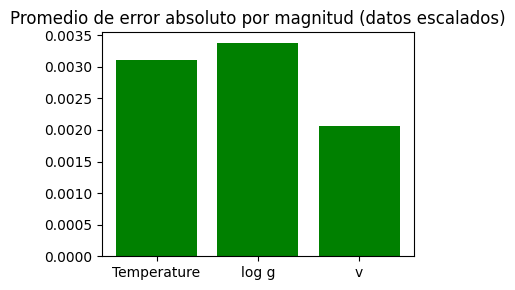

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(ensemble_prediction)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


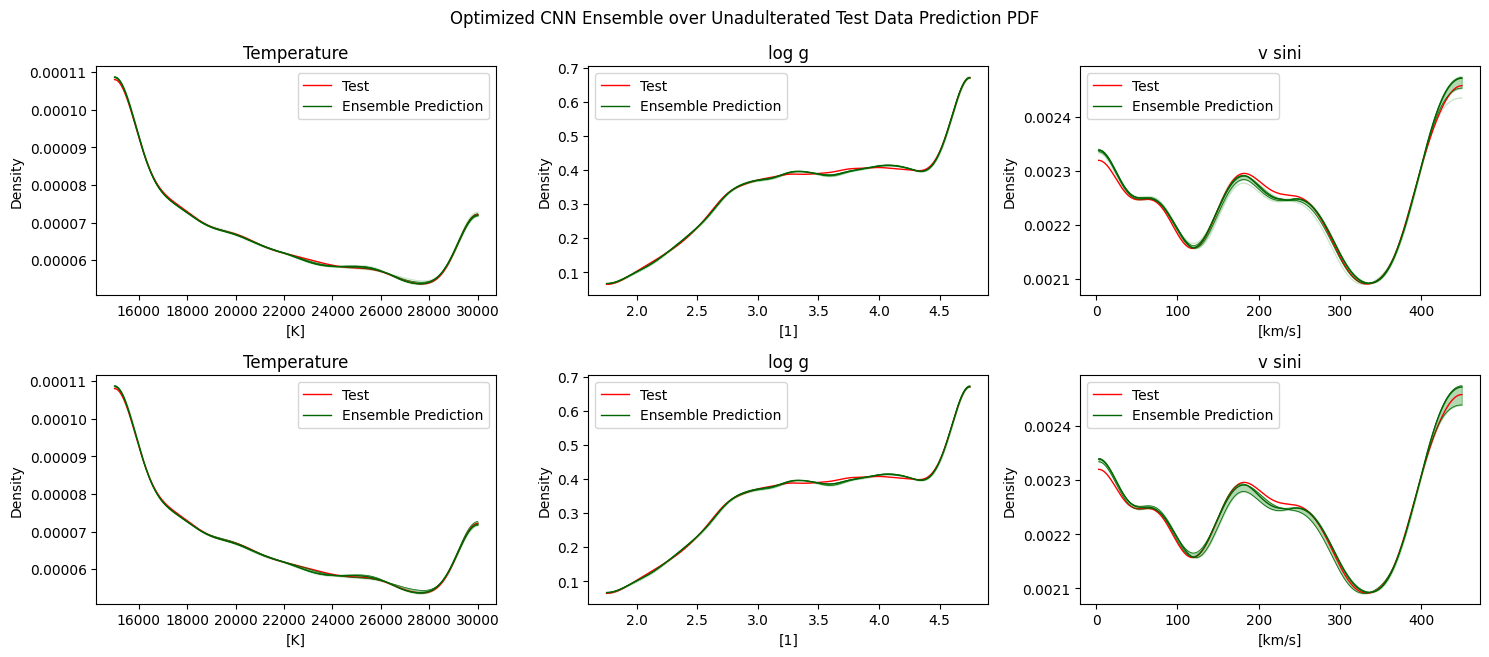

In [36]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')

	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Density')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Density')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])

plt.suptitle('Optimized CNN Ensemble over Unadulterated Test Data Prediction PDF')
plt.tight_layout()
plt.show()

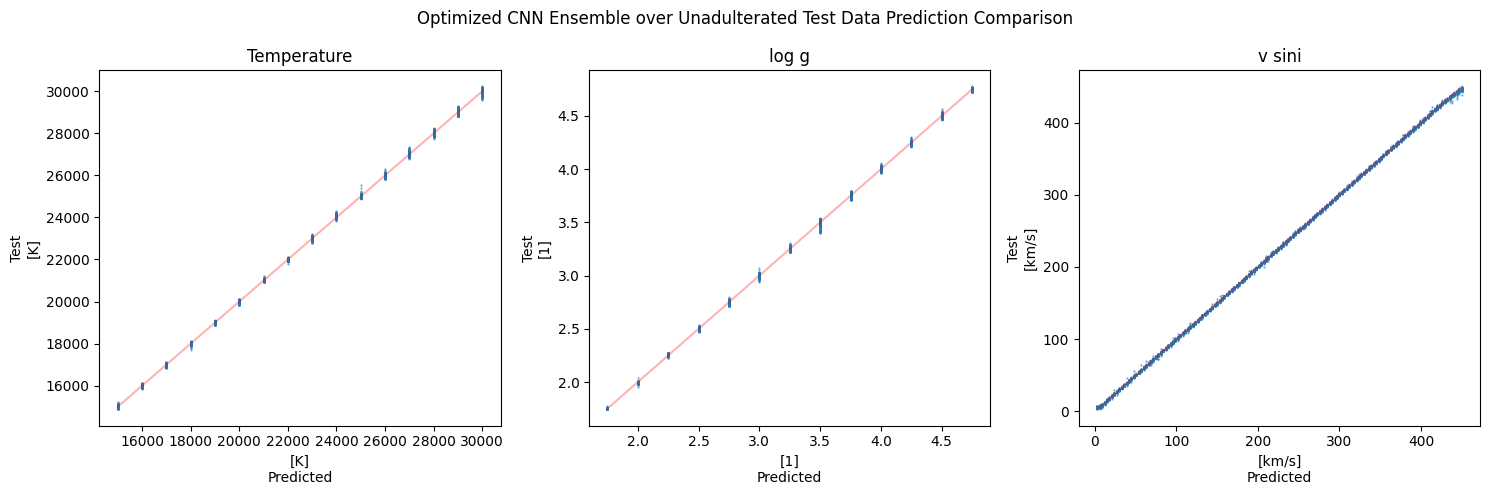

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=ensemble_prediction[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Optimized CNN Ensemble over Unadulterated Test Data Prediction Comparison')
plt.tight_layout();
plt.show()

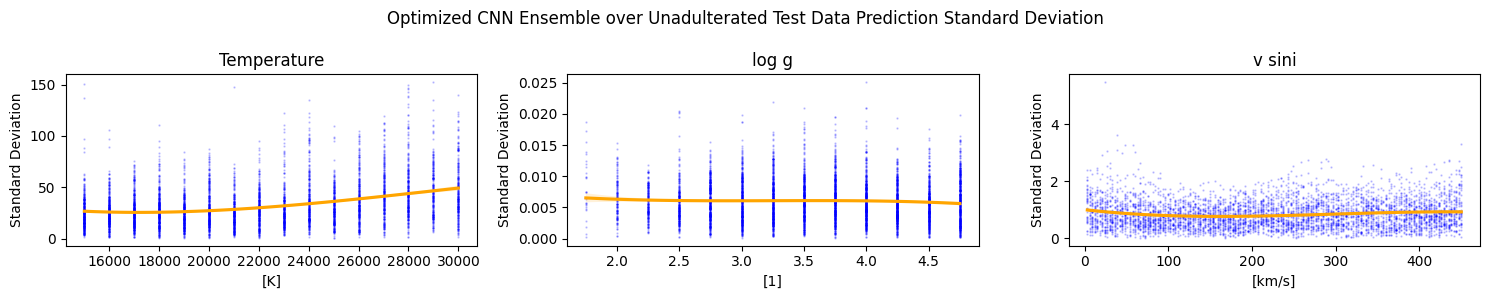

In [38]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temperatura':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temperatura', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Standard Deviation")
	axes[i].set_title(measure[i])
	#axes[i].legend()

plt.suptitle('Optimized CNN Ensemble over Unadulterated Test Data Prediction Standard Deviation')
plt.tight_layout()
plt.show()

In [39]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(ensemble_prediction-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(ensemble_prediction-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [40]:
# dataframe comparativo de datos de testing

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
                    })
results.head(20)

,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,17015 ± 24,15.0 (0.1%),3.25,3.25 ± 0.0,0.0 (0.1%),246,247 ± 1,1.0 (0.4%)
1,18000,18034 ± 42,34.0 (0.2%),2.75,2.77 ± 0.01,0.02 (0.6%),285,284 ± 1,1.0 (0.2%)
2,30000,30170 ± 14,170.0 (0.6%),3.75,3.75 ± 0.01,0.0 (0.0%),267,267 ± 1,0.0 (0.1%)
3,23000,23030 ± 71,30.0 (0.1%),2.5,2.51 ± 0.02,0.01 (0.3%),63,63 ± 1,0.0 (0.1%)
4,19000,18997 ± 36,3.0 (0.0%),3.0,3.0 ± 0.0,0.0 (0.1%),126,124 ± 2,2.0 (1.6%)
5,17000,16985 ± 33,15.0 (0.1%),4.5,4.51 ± 0.01,0.01 (0.3%),156,154 ± 0,2.0 (1.0%)
6,28000,27966 ± 131,34.0 (0.1%),3.25,3.26 ± 0.01,0.01 (0.2%),450,448 ± 2,2.0 (0.3%)
7,22000,22019 ± 10,19.0 (0.1%),4.0,4.01 ± 0.0,0.01 (0.1%),285,284 ± 0,1.0 (0.2%)
8,23000,22977 ± 22,23.0 (0.1%),3.0,3.0 ± 0.0,0.0 (0.1%),30,31 ± 0,1.0 (2.1%)
9,23000,22993 ± 17,7.0 (0.0%),4.5,4.5 ± 0.01,0.0 (0.1%),153,152 ± 0,1.0 (0.7%)


# Espectro Observado

In [41]:
weights_fp = open('./raw_data_predictions/weights.txt','r')
weights = []
predictions = []
for i in range(NUM_MODELS):
    weights.append([1-float(weights_fp.readline().split()[0])])
    test_predictions_fp = open('./raw_data_predictions/obs/'+str(i)+'.predictions.txt','r')
    predictions.append(y_scaler.inverse_transform(read_predictions(test_predictions_fp,len(X_obs))))

weights = np.array(weights)
predictions = np.array(predictions)#.reshape((NUM_MODELS, len(x_test),len(target)))

In [42]:
# prediccion del ensamble e incerteza
weights = [(weight)/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(NUM_MODELS)])
uncertainty = sum([(ensemble_prediction-predictions[i])**2*weights[i] for i in range(NUM_MODELS)])**(1/2)

In [43]:
# metricas por parametro
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((y_scaler.transform(ensemble_prediction)[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(y_scaler.transform(ensemble_prediction)[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.120  MAE:0.282
log g -       loss: 0.187  MAE:0.413
v -           loss: 0.052  MAE:0.201


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

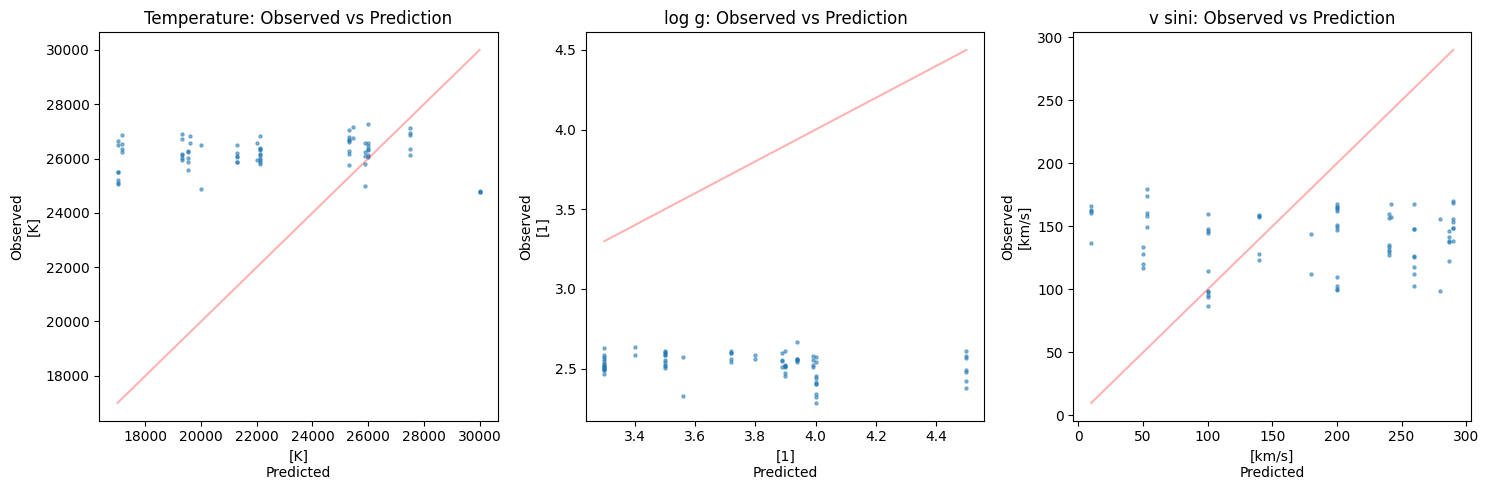

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=ensemble_prediction[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Observed vs Prediction')
 
plt.tight_layout();
plt.show()

In [45]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(ensemble_prediction-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(ensemble_prediction-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [46]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,26277 ± 410,6751.0 (34.6%),3.3,2.53 ± 0.03,0.77 (23.3%),287,138 ± 5,149.0 (52.0%),1015.324415
33328,2013-01-18,03-39-09,19526,25568 ± 276,6042.0 (30.9%),3.3,2.51 ± 0.02,0.79 (24.0%),287,122 ± 2,165.0 (57.3%),1538.537980
33328,2013-02-26,00-55-34,19526,25863 ± 381,6337.0 (32.5%),3.3,2.51 ± 0.03,0.79 (24.0%),287,138 ± 4,149.0 (51.8%),1452.334310
33328,2015-02-25,23-58-07,19526,26028 ± 361,6502.0 (33.3%),3.3,2.51 ± 0.03,0.79 (23.8%),287,146 ± 5,141.0 (49.0%),2072.617893
33328,2015-02-26,00-19-03,19526,26252 ± 380,6726.0 (34.4%),3.3,2.53 ± 0.03,0.77 (23.3%),287,141 ± 6,146.0 (50.7%),2323.030009
35165,2014-03-20,23-53-54,17000,25062 ± 475,8062.0 (47.4%),4.0,2.41 ± 0.02,1.59 (39.9%),240,127 ± 7,113.0 (46.9%),36281.421301
35165,2014-03-21,00-14-49,17000,25096 ± 489,8096.0 (47.6%),4.0,2.41 ± 0.03,1.59 (39.9%),240,135 ± 8,105.0 (43.8%),44058.459074
35165,2014-03-21,00-35-18,17000,25212 ± 494,8212.0 (48.3%),4.0,2.41 ± 0.03,1.59 (39.7%),240,130 ± 7,110.0 (45.9%),51722.541047
35165,2015-11-14,04-22-43,17000,25517 ± 477,8517.0 (50.1%),4.0,2.46 ± 0.03,1.54 (38.6%),240,134 ± 6,106.0 (44.1%),53942.731906
